In [1]:
# Enable code formatting using external plugin: nb_black.
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Linear Regression: Gradient Descent

Ref: [Machine Learning Stanford University][1] (old version) by [Dr. Andrew Ng][2].

## Index

1. [Setup](#[1]-Setup)
2. [Data Analysis](#[2]-Data-Analysis)
3. [Implement Linear Regression](#[3]-Implement-Linear-Regression)
4. [Training Model](#[4]-Training-Model)
5. [Testing Model](#[5]-Testing-Model)

### Objective

Implement multivariate **Linear Regression** using _Gradient Descent_ minimization technique.

[1]: https://www.coursera.org/learn/machine-learning
[2]: https://www.andrewng.org/

<a id="[1]-Setup"></a>
# [1] Setup

### Import and configure required libraries

In [2]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
from prettytable import PrettyTable


# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("PrettyTable version:", prettytable.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Seaborn version: 0.11.2
PrettyTable version: 3.3.0


<IPython.core.display.Javascript object>

#### Common functions

In [3]:
def get_shape(np_array):
    if not isinstance(np_array, np.ndarray):
        raise ValueError(f"Received {type(np_array)} instead of numpy array.")

    if np_array.size == 0:
        raise ValueError("Received empty numpy array.")

    shape = list(np_array.shape)
    return (shape.pop(), None) if len(shape) == 1 else (shape[0], shape[1])


ENABLE_LOG = False


def text(*args):
    """
    Function to print() input string when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)


def texts(nth=10, table=None):
    """
    Function to print() every `nth` input string when logging is enabled.
    """
    itr_count = 0
    count = 0

    def stack(*args):
        """
        Function to print() input string when logging is enabled.
        """
        nonlocal itr_count, count

        itr_count += 1
        count += 1
        if count == nth and ENABLE_LOG is True:
            if table:
                table.add_row([itr_count, *args])
            else:
                print("Itr:", itr_count, "->", *args)

            count = 0

    return stack


def title(title_str, padding=[1, 1], line_style="="):
    """
    Function to print() input string with some styles, when logging is enabled.
    """
    if ENABLE_LOG is True:
        pad_top, pad_bot = padding
        pt = "\n" * pad_top
        pb = "\n" * pad_bot
        print(pt + title_str + "\n" + line_style * len(title_str) + pb)

<IPython.core.display.Javascript object>

#### Load data-points from the `.csv` file

In [4]:
uv_df = pd.read_csv("./univariate_data_points.csv")
uv_df.head()

,X,Y
0,171,183
1,15,84
2,9,85
3,219,228
4,154,199


<IPython.core.display.Javascript object>

<a id="[2]-Data-Analysis"></a>
# [2] Data Analysis

In [5]:
rows, cols = uv_df.shape

print("Rows:", rows)
print("Columns:", cols)

Rows: 500
Columns: 2


<IPython.core.display.Javascript object>

In [6]:
uv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X       500 non-null    int64
 1   Y       500 non-null    int64
dtypes: int64(2)
memory usage: 7.9 KB


<IPython.core.display.Javascript object>

In [7]:
uv_df.apply(max)

X    298
Y    272
dtype: int64

<IPython.core.display.Javascript object>

#### Plot attributes

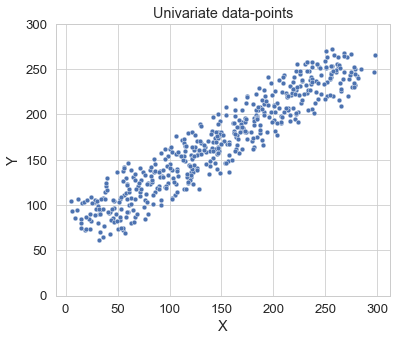

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(6, 5))

sns.scatterplot(data=uv_df, x="X", y="Y")
plt.title("Univariate data-points")
plt.xticks(ticks=range(0, 350, 50))
plt.yticks(ticks=range(0, 350, 50))

plt.show()

<a id="[3]-Implement-Linear-Regression"></a>
# [3] Implement Linear Regression

Implement Linear Regression with below features:

1. Feature Scaling.
2. Regularization.
3. Auto adjusting Learning rate (α).

#### Conventions

1. $m :=$ Total number of training data-points.
2. $X :=$ Input variables / Features
3. $y :=$ Output variable / Target
4. $(x^{(i)}, y^{(i)}) :=$ $i^{th}$ training data-point.
5. $n :=$ Total number of features in the dataset.

### Hypothesis $h_\theta(x)$

$$ \large h_\theta(x) = \theta^{T} \cdot x \\ $$
$$ \text {Where $\vec{x}$ is a vector of length n} $$

$$ \large h_\theta(x) = \theta^{T} \cdot X^{T} \\ $$
$$ \text {Where $X$ is a $m \times n$ matrix} $$

### Model parameters

$$ \large \theta = \theta_0, \theta_1, \theta_2, \dots, \theta_n $$

### Cost Function $J(\theta)$

$$ \large J(\theta) = \frac{1}{2m} \sum_{i = 1}^{m} \bigl(h_{\theta}(x^{(i)}) - y^{(i)}\bigr)^{2} $$

### Cost Function $J(\theta)$ with Regularization

$$
\large
J(\theta)=\frac{1}{2m}\biggl[\sum_{i = 1}^{m}\bigl(h_{\theta}(x^{(i)})-y^{(i)}\bigr)^{2}+\lambda\sum_{j=1}^{n}\theta_j^{2}\biggr] \\
$$
$$ \text {Where $\lambda$ is the Regularization parameter} $$

### Goal

$$ \large \min_{\theta} J(\theta) $$

#### Standardization or Z-score Normalization

In [9]:
def standardization(features):
    """
    Function to implement Standardization or Z-score Normalization.
    """
    # Step 1: Compute mean.
    mean = features.mean(axis=0)

    # Step 2: Compute standard-deviation.
    std = features.std(axis=0)

    def transform(sample=features):
        # Step 3: Remove mean from features.
        z_mean = sample - mean

        # Step 4: Scale features to unit-variance.
        zeros = np.zeros_like(sample, dtype="float")
        return np.divide(z_mean, std, out=zeros, where=std != 0)

    return transform

<IPython.core.display.Javascript object>

#### Plot $J(\theta)$ vs No. of Iterations

In [10]:
def plot_cost_vs_itr(points):
    """
    Function to plot J(θ) vs No. of Iterations to
    check if cost is reducing in each iteration.
    """
    count, _ = get_shape(points)
    text(f"Plotting {count} points:")

    x = points[:, 0]
    y = points[:, 1]

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=x, y=y)
    plt.title("Cost vs Iterations")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost: J(θ)")

    plt.show()

<IPython.core.display.Javascript object>

#### Linear Regression

In [11]:
def linear_regression(X, Y, theta=None, scaling=True):
    """
    Function to implement multivariate Linear Regression
    using Batch Gradient Descent minimization technique.
    """
    LEARNING_RATE = 1
    MAX_ITR = 1000
    PRECISION = 6
    ITR = 100

    """
    By default regularization parameter - 𝜆 - is zero, 
    hence Regularization is "switched off" by default.
    """
    LAMDA = 0  # misspelt to avoid Python keyword `lambda`.

    m, n = get_shape(X)
    # m: Total number of records or data-points
    # n: Total number of input-variables or features.

    if not n:
        # Reshape NumPy array to vector.
        text("Reshaping NumPy array, univariate feature, to vector.")
        X = X.reshape((m, 1))

    transform = standardization(X)

    def preprocess(features):
        """
        Closure to preprocess input variables:
            1. Feature scaling.
            2. Adding dummy feature theta-zero.
        """
        rows, cols = get_shape(features)

        if scaling:
            # Scaling feature b/w the range -1 std-dev and +1 std-dev.
            features = transform(features)  # Standardized features.

        # Add dummy feature X0 for y-intercept into features
        X_0 = np.ones((rows, 1), features.dtype)
        return np.hstack((X_0, features))  # Concatenate horizontally.

    # Preprocessing features.
    X = preprocess(X)

    # Get final shape after preprocessing.
    m, n = get_shape(X)

    # Initialize empty model parameters if not present.
    if not theta:
        theta = np.zeros(n)

    def fit(alpha=LEARNING_RATE, max_itr=MAX_ITR, lamda=LAMDA, nth=ITR, plot_cost=False, precision=PRECISION):
        """
        Fit model parameters(θ) to the dataset i.e., train model using Linear Regression.
        """
        nonlocal theta

        # Add lambda 0 for dummy feature X0.
        lamdas = [0]
        # Use the provided lambda value for remaining features.
        lamdas[1:] = [lamda] * (n - 1)
        lamdas = np.array(lamdas)

        title("Linear Regression")
        text("Model Attributes:")
        text("\tX shape:", get_shape(X))
        text("\tY shape:", get_shape(Y))
        text("\tθ shape:", get_shape(theta))

        # Function to compute hypothesis using matrix multiplication technique.
        # This hypothesis is a Linear Regression model.
        h = lambda X: np.matmul(theta, X.transpose())

        def get_cost():
            """
            Closure to compute cost of the prediction using hypothesis.
            """
            error = h(X) - Y
            reg_val = np.sum(lamdas * theta**2)  # Regularization: Penalizing thetas.
            cost = (np.sum(error**2) + reg_val) / (2 * m)

            return round(cost, precision)

        def gradient_descent(alpha=LEARNING_RATE):
            """
            Closure to compute derivative of Squared Error cost function for
            Gradient Descent algorithm using matrix multiplication technique.
            """
            error = h(X) - Y
            p_theta = lamdas * theta  # Regularization: Penalizing thetas.
            slope = (alpha / m) * (np.matmul(X.transpose(), error) + p_theta)

            # Round off and return updated Theta.
            return np.around(theta - slope, precision)

        text("\nModel training started.")
        table = PrettyTable(["Itr", "Cost", "Model parameters"])
        stack = texts(nth, table)

        costs = []
        for itr in range(0, max_itr):
            j_theta = get_cost()
            theta = gradient_descent(alpha)
            stack(j_theta, theta.tolist())

            # Accumulate iteration count and cost for plotting.
            costs.append([itr, j_theta])

        text(table)
        text("Model training complete!\n")

        if plot_cost:
            plot_cost_vs_itr(np.array(costs))

        def predict(features, precision=PRECISION):
            """
            Closure to predict target value for the given features.
            """
            # Preprocessing features before predicting target.
            pp_f = preprocess(np.array(features, ndmin=2))

            # Predict and return target value.
            y = round(h(pp_f).item(), precision)
            return (y, theta.tolist())

        return predict

    return fit

<IPython.core.display.Javascript object>

> Note: In the above code $\lambda$ is declared as `lamda` purposefully, to avoid Python keyword `lambda`.

<a id="[4]-Training-Model"></a>
# [4] Training Model

#### Initialize Regressor

In [12]:
ENABLE_LOG = True

X = uv_df["X"].values
Y = uv_df["Y"].values

fit = linear_regression(X, Y)

Reshaping NumPy array, univariate feature, to vector.


<IPython.core.display.Javascript object>

Train model using training dataset.

> Note: Set `ENABLE_LOG` to `False` to train model silently (without logs)


Linear Regression

Model Attributes:
	X shape: (500, 2)
	Y shape: (500, None)
	θ shape: (2, None)

Model training started.
+-----+----------+---------------------+
| Itr |   Cost   |   Model parameters  |
+-----+----------+---------------------+
|  5  | 414.4521 | [155.6612, 46.4156] |
|  10 | 155.5032 | [167.7655, 50.0249] |
|  15 | 153.9376 | [168.7067, 50.3055] |
|  20 | 153.9281 | [168.7798, 50.3273] |
|  25 | 153.928  | [168.7855, 50.3291] |
+-----+----------+---------------------+
Model training complete!

Plotting 25 points:


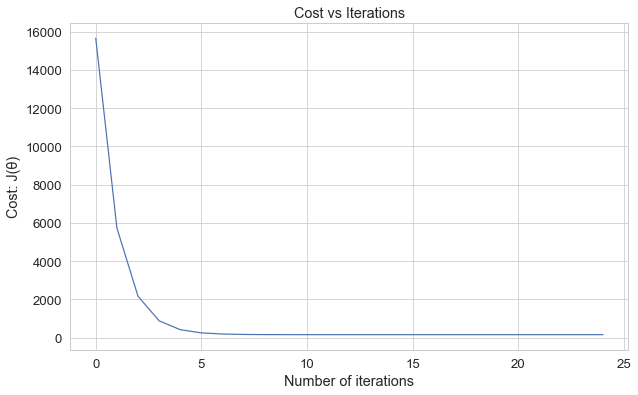

<IPython.core.display.Javascript object>

In [13]:
# Fit Linear Regression model.
predict = fit(alpha=0.4, max_itr=25, lamda=0.00001, nth=5, plot_cost=True, precision=4)
# nth := Print cost and model parameters every nth iteration.

<a id="[5]-Testing-Model"></a>
# [5] Testing Model

#### Test 1: Univariate dataset

In [14]:
x = [200]
y, model_prms = predict(x, precision=3)

print("Output:")
print("Input features:", x),
print("Predicted target:", y)
print("Model parameters fit to the dataset:", model_prms)

Output:
Input features: [200]
Predicted target: 204.771
Model parameters fit to the dataset: [168.7855, 50.3291]


<IPython.core.display.Javascript object>

#### Plot Model

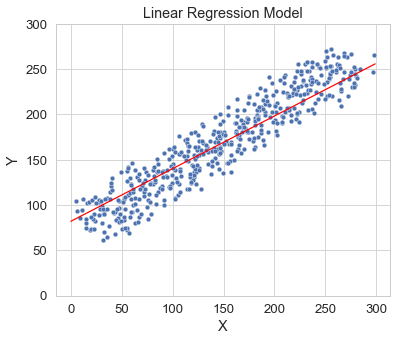

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(6, 5))

t0, t1 = model_prms

x = np.arange(0, 300)
transform = standardization(x)
xt = transform()
y = [t0 + t1 * i for i in xt]

# Model
sns.lineplot(x=x, y=y, color="red")

# Data points
sns.scatterplot(data=uv_df, x="X", y="Y")
plt.title("Linear Regression Model")
plt.xticks(ticks=range(0, 350, 50))
plt.yticks(ticks=range(0, 350, 50))

plt.show()

#### Test 2: Multivariate dataset


Linear Regression

Model Attributes:
	X shape: (5, 4)
	Y shape: (5, None)
	θ shape: (4, None)

Model training started.
+-----+---------+------------------------------------+
| Itr |   Cost  |          Model parameters          |
+-----+---------+------------------------------------+
|  5  | 29.9724 | [298.9075, 0.9409, 0.8782, 0.3732] |
|  10 |  0.0599 | [301.9683, 0.8908, 1.0523, 0.5448] |
|  15 |  0.0523 | [301.9997, 0.8684, 1.1192, 0.6105] |
|  20 |  0.0516 |  [302.0, 0.8597, 1.1452, 0.6359]   |
|  25 |  0.0515 |  [302.0, 0.8563, 1.1553, 0.6458]   |
+-----+---------+------------------------------------+
Model training complete!

Plotting 25 points:


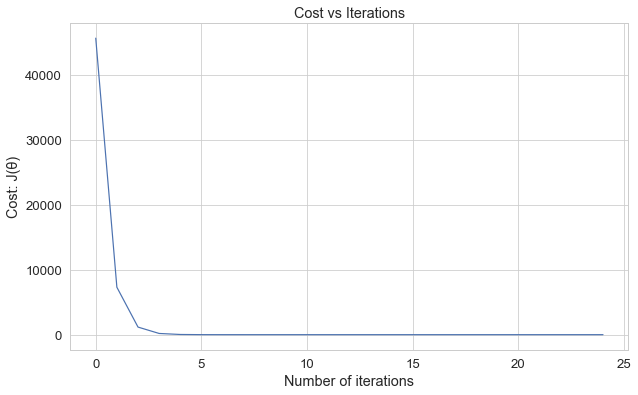

Output:
Input features: [29, 4, 101]
Predicted target: 303.875
Model parameters fit to the dataset: [302.0, 0.8563, 1.1553, 0.6458]


<IPython.core.display.Javascript object>

In [16]:
ENABLE_LOG = True

X = np.array(
    [
        [20, 2, 100],
        [26, 1, 103],
        [25, 0, 109],
        [24, 5, 102],
        [29, 4, 100],
    ]
)
Y = np.array([300, 301, 302, 303, 304])

# Initialize Regressor
fit = linear_regression(X, Y)

# Fit Linear Regression model.
predict = fit(alpha=0.6, max_itr=25, lamda=0.00001, nth=5, plot_cost=True, precision=4)

# Predict target.
x = [29, 4, 101]
y, model_prms = predict(x, precision=3)

print("Output:")
print("Input features:", x),
print("Predicted target:", y)
print("Model parameters fit to the dataset:", model_prms)